## Stochastic-gradient MCMC for neural networks

This notebook is for hands-on exercises during the Wednesday afternoon lecture.

In the first exercise, you will implement SGD for sampling. The notebook already provides all basic definitions, including data generation and model specification, and you will only need to figure our how to set the learning rate correctly for sampling with the standard SGD.

During the second break, we will work on SGLD. You will extend SGD to include additional noise and hence implement SGLD. You can also try implementing MALA, by adding Metropolis-Hasting rejection step.

**DISCLAIMER**: Never use these code snippets for real problems. The notebook is purely for pedagogical reasons and the algorithms are extremely fragile and likely also buggy.

In [1025]:
# Basic libraries
import torch
import copy
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

### Various choices

These control what kind of data is generated and how many iterations we run the algorithms. Feel free to play around with these!

In [1026]:
# Set these to True to play around with a simple non-linear data
nonlinearData = True
nonlinearModel = True
K = 4                    # Number of neurons in a hidden layer in the non-linear model

N = 256                  # Amount of (training) data
noiseStd = 0.2           # Noise std for data generation
batch_size = 32          # Minibatch size (NOTE: This will be overriden in some later cells!)
nEpoch = 1000            # Number of iterations (passes through the whole data) for optimization
nSampling = 1000         # The same but for the sampling phase
skip = 20                # Sampling interval -- keep only every skip:th sample

### Define the models

Two alternative models: A simple non-linear model and a linear one that makes visualization of the posterior easy as it only has two parameters here.

In [1027]:
class nonlinear(nn.Module):
  def __init__(self, D_i, D_o, K):
      super().__init__()
      self.fc = nn.Linear(D_i, K)
      self.fc2 = nn.Linear(K, K)
      self.out = nn.Linear(K, D_o)

  def forward(self, x):
      x = self.fc(x)
      x = nn.functional.tanh(x)
      x = self.fc2(x)
      x = nn.functional.tanh(x)
      x = self.out(x)
      return x

class linear(nn.Module):
  def __init__(self, D_i, D_o):
      super().__init__()
      self.fc = nn.Linear(D_i, D_o)

  def forward(self, x):
      x = self.fc(x)
      return x


### Define the objective

We assume the likelihood $\mathcal{N}(f(x), \sigma^2)$ where $f(x)$ is the output of the prediction and the noise variance $\sigma^2$ *is assumed to be known*. In practice this is the same things as regular mean-squared-error but we explicitly scale the objective with the noise to make sure has an interpretation as a likelihood. We could also consider $\sigma^2$ as a random variable so that we would do Bayesian inference also over that -- think about how this would be done.

The loss is written as the expected contribution for a **single data point**, $\mathcal{L} = \mathbb{E}[\log p(y|x)]$. That is, the full log-likelihood would be $N \mathcal{L}$. Writing the loss this way makes gradients and losses computed over minibatches of different size comparable and hence we do not need to change the step-length proportionally to the minibatch size, but we need to be careful in other aspects:
1. Proper scaling of a prior is using one. The additive term needs to be $\frac{1}{N} \log p(\theta)$ so that it is on the right scale
2. When evaluating actual probabilities, for example to compute MH acceptance ratios, we need to scale the loss with $N$

When reading papers about stochastic-gradient MCMC methods you need to check how they define this! Mandt et al. specifically use the per-sample losses and gradients when deriving the results for SGD, but Welling and Teh use the actual log-probability for SGLD.

In [1028]:
class NLLLossNormal(nn.Module):
    def __init__(self, variance):
        super(NLLLossNormal, self).__init__()
        self.variance = torch.tensor(variance)

    def forward(self, predictions, targets):
        # Negative log-likelihood
        log_likelihood = - 0.5 * (torch.log(2. * torch.pi * self.variance) + 
                                 (predictions - targets) ** 2 / self.variance)
        return -torch.mean(log_likelihood)


class NLLLossNormalSum(nn.Module):
    def __init__(self, variance):
        super(NLLLossNormalSum, self).__init__()
        self.variance = torch.tensor(variance)

    def forward(self, predictions, targets):
        # Negative log-likelihood
        log_likelihood = - 0.5 * (torch.log(2. * torch.pi * self.variance) + 
                                 (predictions - targets) ** 2 / self.variance)
        return -torch.sum(log_likelihood)

### Create data

Code for creating data for simple one-dimensional regression. The inference should work also for higher-dimensional problems, but all plotting functionality assumes we have 1D inputs and outputs.

In [1029]:
# Data available for training
xobs = torch.rand(N,1)*10. - 5.
if nonlinearData:
    ynonoise = torch.sin(xobs/1.)
else:
    ynonoise = xobs/10
yobs = ynonoise + torch.randn(N,1)*noiseStd

# Test grid for plotting the full function
G = 500
xgrid = torch.linspace(-5.0,5.0,G).resize(G,1)
if nonlinearData:
    yfull = torch.sin(xgrid/1.)
else:
    yfull = xgrid/10.

# Create mini-batches
dataset = TensorDataset(xobs, yobs)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Plotting functions

The first plots the distribution over the functions, showing the true function, the mean estimate and all individual samples.

The latter plots the posterior over the first two parameters of the model. This takes an extra argument that helps in zooming around the part of the parameter space around the MAP estimate of the linear model for ease of interpretation.

In [1030]:
def plot_functions(x, true, data_x, data_y, pred):
    for i in range(pred.shape[1]):
        plt.plot(x, pred[:,i], alpha=0.1, color='r')
    plt.plot(x, np.average(pred, axis=1), color='b')
    plt.plot(x, true, color='k')
    plt.plot(data_x, data_y, '.', color='k')
    #plt.legend(['-r','-b','-k'],['Posterior samples','Mean prediction','True function'])


def plot_posterior(weights, linearLimits=True):
    flattened_weights = []
    for w in weights:
        # Stack the list of tensors into a single tensor
        flat_tensor = torch.cat([param.flatten() for param in w.values()])
        flattened_weights.append(flat_tensor)
    posterior = torch.stack(flattened_weights).detach().numpy()

    plt.plot(posterior[:,0], posterior[:,1], '.', color='r')
    # Fix plotting range for the case where we know the true answer
    if linearLimits:
        plt.ylim([-0.3, 0.3])
        plt.xlim([-0.3, 0.3])
        plt.plot([0.1],[0.0],'*',color='k')


## EXERCISE 1: SGD as a sampling algorithm

Implement SGD as a sampling algorithm by completing the three steps:
1. First find the optimum using standard SGD
2. Estimate the covariance of the noise caused by using minibatches for estimating the gradient, and use it tolve for the optimal **scalar** step length (you can also try a vector-valued one if you want)
4. Run the algorithm for enough iterations with the right step length, storing the results

### Step 1: Standard optimization

Standard optimization loop that can be used for finding the best possible solution. We will be using the code as a starting point for sampling, since this is the first part of the "SGD as sampling" algorithm.

**Do not proceed** until you you have checked that you find good enough optimum. The rest of the algorithm will not be correct if we are not close to the mode.

Final loss -0.11247299611568451
Optimal loss -0.1793411821126938


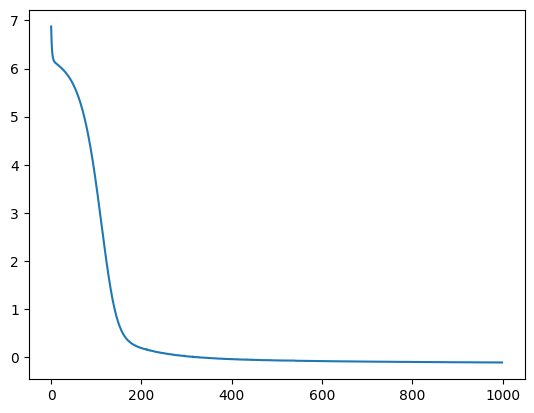

In [1031]:
# Initialize the model
if nonlinearModel:
    model = nonlinear(1,1,K)
else:
    model = linear(1,1)

# Optimizer
model.train()
objective = NLLLossNormal(variance=noiseStd**2.)
optimizer = torch.optim.SGD(model.parameters(), lr=0.02*noiseStd**2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

losses = []
weights = []
for i in range(nEpoch):
    for batch_input, batch_target in data_loader:
        optimizer.zero_grad()
        pred = model(batch_input)
        loss = objective(pred, batch_target)
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Track loss using full batch data (we do not care about effiency here)
    optimizer.zero_grad()
    pred = model(xobs)
    loss = objective(pred, yobs)
    losses.append(loss.item())

    # Store the parameters using deepcopy to make sure they are not references
    # NOTE: If you want to try out the plotting functionality before implementing the sampler,
    # you can skip from here to that cell and see how it looks like with samples stored during optimization
    if (i + 1) % skip == 0:
        weights.append(copy.deepcopy(model.state_dict()))

# Check we optimized well enough. We know the objective for the true function and should be getting close to that.
print("Final loss", losses[-1])
print("Optimal loss", objective(ynonoise,yobs).item())
plt.plot(losses)
plt.show()

# Store the optimized model
optimized = copy.deepcopy(model.state_dict())

### Step 2: Estimate the covariance

Implement below a piece of code that estimates the noise covariance. We will only be needing the diagonal of the covariance, so no need to estimate the whole covariance matrix.

1. Loop over the minibatches and evaluate $\mathbb{E}[(g_b-\bar g)^2]$ where $g_b$ is the minibatch gradient and $\bar g$ is the real gradient (that is also the average over the minibatch gradients). Re-scale this to get an estimate of the *per-sample* gradient noise, using the rule that the variance goes down linearly as a function of the minibatch size.
2. Estimate the best scalar learning rate, and perhaps also the best vector-valued learning rate using the equatons given in the slides. Remember that trace of a diagonal matrix is the sum of the entries on the diagonal, and we are here storing only the diagonal elements.

The cell already has some hints on how to manipulate the gradient objects; this is definitely not the only way but helps to get started if you are not very fluent in PyTorch.

In [1032]:
model.eval()

# Compute the mean gradient, by *not* taking a minibatch
optimizer.zero_grad()
pred = model(xobs)
loss = objective(yobs, pred)
loss.backward()
gradmean = {name: param.grad.clone() for name, param in model.named_parameters()}

# Compute the diagonal covariance over the minibatches
BB = {}
batches = 0
for batch_input, batch_target in data_loader:
    optimizer.zero_grad()
    pred = model(batch_input)
    loss = objective(pred, batch_target)
    loss.backward()
    batches += 1

    for name, param in model.named_parameters():
        if param.grad is not None:
            variance = (param.grad - gradmean[name]) ** 2.
            if name not in BB:
                BB[name] = torch.zeros_like(param.grad)
            BB[name] += variance

# Normalize and compute dimensionality
TraceBB = 0.
D = 0.
for name, param in model.named_parameters():
    D += param.shape[0]
    # We want average over the batches, not sum
    BB[name] /= float(batches)
    # Scale so that BB^T is for the single-sample noise, not for the mini-batch
    BB[name] *= batch_size
    # Trace of a diagonal matrix is sum of the diagonal entries    
    TraceBB += BB[name].sum()

# We now have:
# - D is the number of parameters
# - BB is a dictionary similar to the gradient, but having the per-sample diagonal covariance
# - TraceBB is the trace of that

print("Observations: ", N)
print("Dimensionality: ", D)
print("Batch size: ", batch_size)
print("Trace of noise covariance: ",TraceBB)

eps = 2. * batch_size / N * D / TraceBB
print("Scalar learning rate: ",eps)

eps_vector = {name: 2.*batch_size / (N * BB[name]) for name, param in model.named_parameters()}
print("Vector-valued learning rate:", eps_vector)

Observations:  256
Dimensionality:  18.0
Batch size:  32
Trace of noise covariance:  tensor(1122.9838)
Scalar learning rate:  tensor(0.0040)
Vector-valued learning rate: {'fc.weight': tensor([[0.0174],
        [0.0019],
        [0.0023],
        [0.0008]]), 'fc.bias': tensor([0.0054, 0.0157, 0.0188, 0.0075]), 'fc2.weight': tensor([[0.7988, 1.0068, 0.7697, 2.8026],
        [0.0068, 0.0108, 0.0076, 0.0150],
        [0.1272, 0.1958, 0.1397, 0.2550],
        [0.0040, 0.0064, 0.0045, 0.0084]]), 'fc2.bias': tensor([0.7948, 0.0077, 0.1314, 0.0043]), 'out.weight': tensor([[0.0315, 0.1283, 0.1572, 0.2185]]), 'out.bias': tensor([0.0088])}


#### Step 3: Sample using the right learning rate

Now run the actual sampler. This goes exactly like in the initial optimization phase, but now we should:
1. Start from the already trained solution, to guarantee we are around the MAP estiamte
2. Use a constant learning rate -- no scheduler!
3. Store samples every now and then

In [1033]:
# Start from the model we trained
model.load_state_dict(optimized)

# Scalar or vector-valued learning rate
vector_valued = False

optimizer = torch.optim.SGD(model.parameters(), lr=eps)

weights = []
for i in range(nSampling):
    for batch_input, batch_target in data_loader:
        optimizer.zero_grad()
        pred = model(batch_input)
        loss = objective(pred, batch_target)
        loss.backward()

        # Vector-valued optimization implemented manually
        if vector_valued:
            with torch.no_grad():
                for name, param in model.named_parameters():
                    param -= eps_vector[name] * param.grad 
        else:
            optimizer.step()

    # Store the parameters using deepcopy to make sure they are not references
    if (i + 1) % skip == 0:
        weights.append(copy.deepcopy(model.state_dict()))

### Evaluation: Make predictions with all models and plot the results

Let's evaluate how the model works. Once you can see it does something reasonable, try playing around with:
1. N and the batch size
2. Linear and non-linear data

The code below already has plotting functionality that should work for any collection of models stored 'weights'. The first plot shows the functions, the latter the posterior over the first two parameters of the model. For the linear model it already zooms to the right area of the parameter space for the specific linear data used in this notebook.

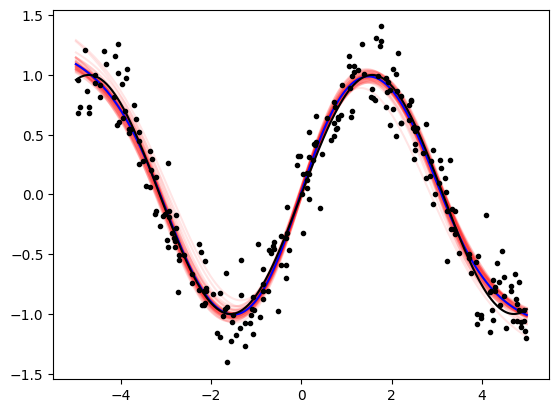

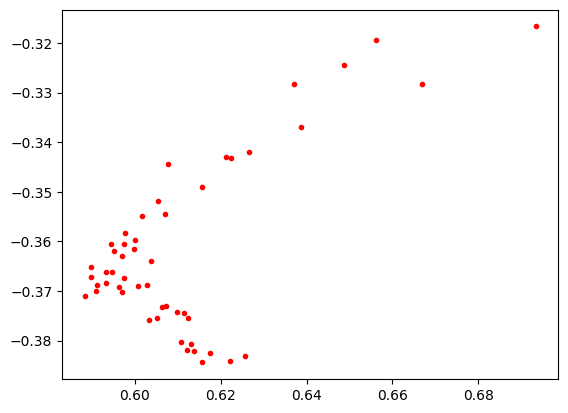

In [1034]:
# Make predictions with all stored weights
preds = []
for i in range(len(weights)):
    model.load_state_dict(weights[i])
    model.eval()
    preds.append(model(xgrid))
pred = torch.cat(preds,dim=1)

plot_functions(xgrid.detach().numpy(), yfull.detach().numpy(), xobs.detach().numpy(), yobs.detach().numpy(), pred.detach().numpy())
plt.show()

plot_posterior(weights,not nonlinearModel)
plt.show()

## EXERCISE 2: Stochastic gradient Langevin dynamics

Implement SGLD:
1. Write a standard SGD optimization loop, with suitable learning rate scheduling
2. Add explicit Gaussian noise after making the gradient step (or replace the gradient step with a manual update)
3. Store samples as before and average predictions over the posterior. Run the sampler for nEpochs + nSampling and only store samples during the latter stage.

Track somehow the learning rates during the algorithm and try to evaluate whether we are in the SGLD sampling regime. According to the theory, we should be having the injective noise dominating the gradient noise, which we could try to validate using:
- The gradient noise is proportional to $\epsilon^2$ but also $BB^T$
- The injected noise variance is $2 \epsilon$


Initial learning rate:  1.2500000000000002e-05
Learning rate when entering sampling:  1.0233008662612828e-05
Final learning rate:  9.260088846886426e-06
Injected noise variance:  1.3095743236046619e-05
Gradient noise variance:  tensor(5.3497e-09)
Final loss -25.982563018798828
Optimal loss -45.91134262084961


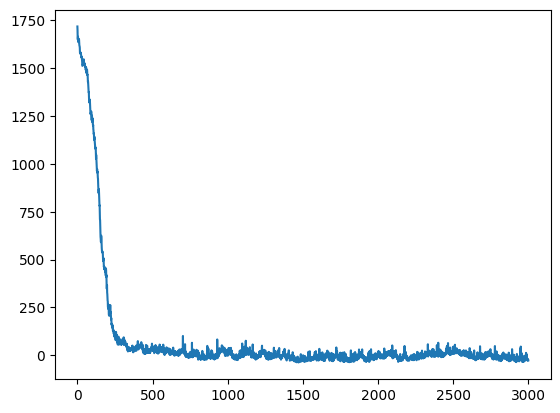

In [1035]:
# Initialize the model
if nonlinearModel:
    model = nonlinear(1,1,K)
else:
    model = linear(1,1)

model.train()

objective = NLLLossNormalSum(variance=noiseStd**2.)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01*noiseStd**2 / batch_size)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

print("Initial learning rate: ", scheduler.get_last_lr()[0])

# Sampling loop
losses = []
weights = []
nEpoch = 2000
for i in range(nEpoch + nSampling):
    for batch_input, batch_target in data_loader:
        optimizer.zero_grad()
        pred = model(batch_input)
        loss = objective(pred, batch_target)
        loss.backward()

        # Replace standard gradient update with a manual one where we make a gradient step and add noise as well
        # Since we use lr directly as the learning rate, we need to multiply the noise scale with sqrt(2)
        scale = np.sqrt(scheduler.get_last_lr()[0]) * np.sqrt(2)
        with torch.no_grad():
            proposal = {name: param - scheduler.get_last_lr()[0]*param.grad + scale*torch.randn_like(param) for name, param in model.named_parameters()}
            model.load_state_dict({name: proposal[name] for name in proposal})

    # Decrease learning rate
    scheduler.step()

    # Track loss using full batch data (we do not care about effiency here)
    optimizer.zero_grad()
    pred = model(xobs)
    loss = objective(pred, yobs)
    losses.append(loss.item())

    if (i == nEpoch):
        print("Learning rate when entering sampling: ", scheduler.get_last_lr()[0])
    
    if (i > nEpoch) and ((i + 1) % skip == 0):
        weights.append(copy.deepcopy(model.state_dict()))

print("Final learning rate: ", scheduler.get_last_lr()[0])

# Fragile code that directly uses old TraceBB (only makes sense if you ran things consecutively)
print("Injected noise variance: ", np.sqrt(2)*scheduler.get_last_lr()[0])
print("Gradient noise variance: ", scheduler.get_last_lr()[0]**2.*TraceBB/D)

# Check we optimized well enough. We know the objective for the true function and should be getting close to that.
print("Final loss", losses[-1])
print("Optimal loss", objective(ynonoise,yobs).item())
plt.plot(losses)
plt.show()

### Evaluation

Look at the same things as below. Again try to play around with $N$ and batch size, but also with the initial learning rate and the scheduling. You might find the results quite sensitive to the learning rate.

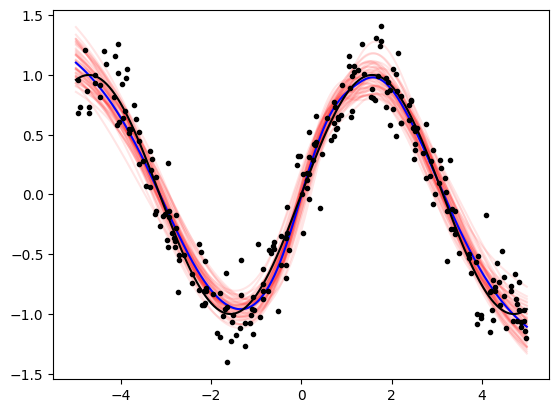

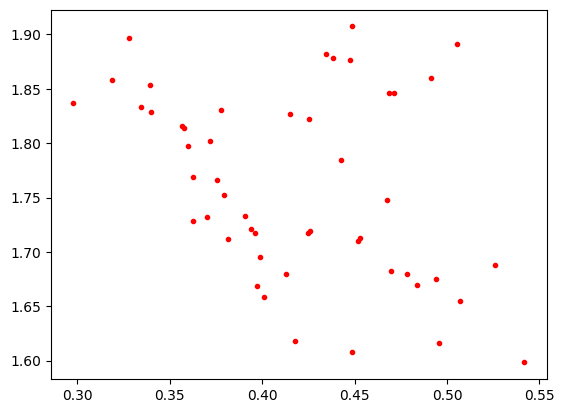

In [1036]:
preds = []
for i in range(len(weights)):
    model.load_state_dict(weights[i])
    model.eval()
    preds.append(model(xgrid))
pred = torch.cat(preds,dim=1)

plot_functions(xgrid.detach().numpy(), yfull.detach().numpy(), xobs.detach().numpy(), yobs.detach().numpy(), pred.detach().numpy())
plt.show()

plot_posterior(weights, not nonlinearModel)
plt.show()

### Exercise 2 (BONUS): Metropolis-adjusted Langevin algorithm (MALA)

If you have time after completing the SGLD, feel free to attempt implementing the full MALA algorithm.

1. Proceed using the same basic loop, but now instead of optimizet.step() you need to *propose* a new configuration while storing still the old one. Compute the likelihood for the new configuration.
2. Form explicitly a normal distribution with the centroid at the gradient step and the covariance matching the additive noise, and compute the proposal distribution q().
3. Do the same to the opposite direction! Assume we are at the newly proposed configuration, evaluate gradients etc from there and again form the proposal distribution as well.
4. Finally, use MH to select whether we keep the new proposal or not.

Do not worry about computational efficiency at all.

Initial learning rate:  0.00012500000000000003
Learning rate when entering sampling:  0.00010233008662612778


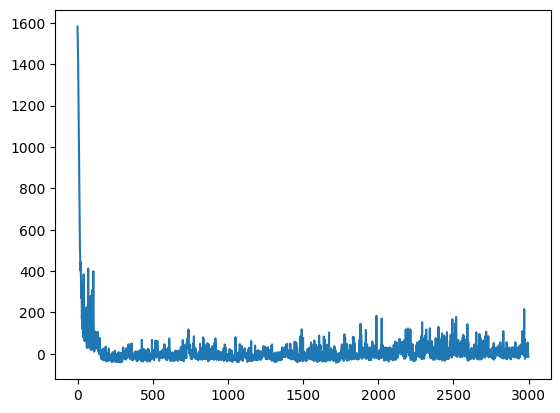

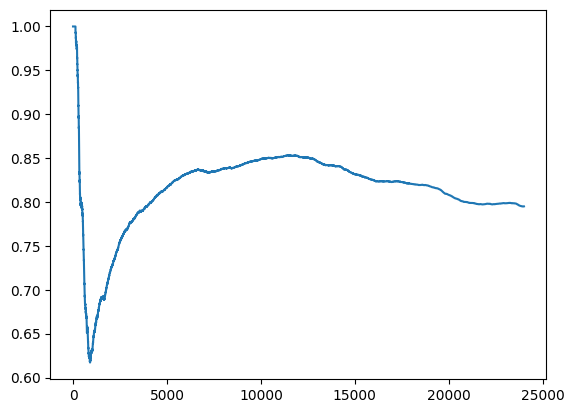

Acceptance ratio: 0.7949583333333333
Final learning rate 9.261014948381227e-05
Final loss -14.667076110839844
Optimal loss -45.91134262084961


In [1037]:
# Start from the model we trained, just to avoid needig to find the mode again
#model.load_state_dict(optimized)
# Initialize the model
if nonlinearModel:
    model = nonlinear(1,1,K)
else:
    model = linear(1,1)

MHcheck = True

model.train()
objective = NLLLossNormalSum(variance=noiseStd**2.)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1*noiseStd**2 / batch_size)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

print("Initial learning rate: ", scheduler.get_last_lr()[0])

# Sampling loop
losses = []
weights = []
accepted = []
total = 0
nEpoch = 2000
for i in range(nEpoch + nSampling):
    for batch_input, batch_target in data_loader:
        # Store current weights, we need them for evaluating the acceptance and may need to return to that state
        current = copy.deepcopy(model.state_dict())

        lr = scheduler.get_last_lr()[0]
        
        # Find the current gradient
        optimizer.zero_grad()
        pred = model(batch_input)
        loss = objective(pred, batch_target)
        loss.backward()

        # Make a proposal distribution, a Gaussian with:
        # - Centroid is current parameters - gradient with the right step length
        # - Covariance is diagonal with the right variance
        # - The actual proposal is a sample from that distribution
        mu = {name: param - lr*param.grad for name, param in model.named_parameters()}
        with torch.no_grad():
            proposal = {name: mu[name] + np.sqrt(2.*lr)*torch.randn_like(param, dtype=param.dtype, device=param.device) for name, param in model.named_parameters()}
            model.load_state_dict({name: proposal[name] for name in proposal})

        
        # The Metropolis-Hastings step
        if MHcheck:
            # Evaluate the log-likelihood and the proposal q()
            # Note that objective is minus log-likelihood, so now we need to take its negative
            pred = model(batch_input)
            new_log_prob = -objective(pred, batch_target)
            q_old_to_new = 0.
            for name, param in model.named_parameters():
                q_old_to_new += torch.distributions.Normal(mu[name].flatten(), np.sqrt(2.*lr)).log_prob(proposal[name].flatten()).sum()
    
            # Form the opposite proposal:
            # Gradient from that point
            optimizer.zero_grad()
            pred = model(batch_input)
            loss = objective(pred, batch_target)
            loss.backward()
            # Centroid, log-probability and proposal q()
            # Need to swith back to the old state to evaluate its probability
            mu2 = {name: param - lr*param.grad for name, param in model.named_parameters()}
            model.load_state_dict({name: current[name] for name in current})
            pred = model(batch_input)
            old_log_prob = -objective(pred, batch_target)
            q_new_to_old = 0.
            for name, param in model.named_parameters():
                q_new_to_old += torch.distributions.Normal(mu2[name].flatten(), np.sqrt(2.*lr)).log_prob(current[name].flatten()).sum()
    
            # Perform the MH acceptance check and track acceptance ratio
            ratio = torch.exp(new_log_prob - old_log_prob + q_new_to_old - q_old_to_new)
            if torch.rand(1) < ratio:
                model.load_state_dict({name: proposal[name] for name in proposal})
                accepted.append(1)
            else:
                model.load_state_dict({name: current[name] for name in current})
                accepted.append(0)
            total += 1

    scheduler.step()

    # Track loss using full batch data (we do not care about effiency here)
    optimizer.zero_grad()
    pred = model(xobs)
    loss = objective(pred, yobs)
    losses.append(loss.item())

    if (i == nEpoch):
        print("Learning rate when entering sampling: ", scheduler.get_last_lr()[0])

    if (i > nEpoch) and ((i + 1) % skip == 0):
        weights.append(copy.deepcopy(model.state_dict()))

plt.plot(losses)
plt.show()
if MHcheck:
    plt.plot(np.cumsum(accepted)/np.cumsum(np.ones(len(accepted))))
    plt.show()
    print("Acceptance ratio:", sum(accepted)/total)

print("Final learning rate", lr)
print("Final loss", losses[-1])
print("Optimal loss", objective(ynonoise,yobs).item())


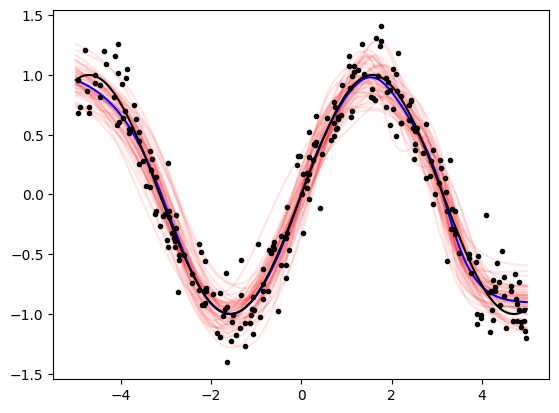

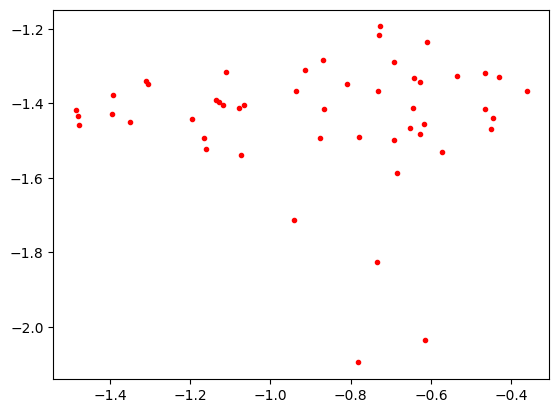

In [1038]:
preds = []
for i in range(len(weights)):
    model.load_state_dict(weights[i])
    model.eval()
    preds.append(model(xgrid))
pred = torch.cat(preds,dim=1)

plot_functions(xgrid.detach().numpy(), yfull.detach().numpy(), xobs.detach().numpy(), yobs.detach().numpy(), pred.detach().numpy())
plt.show()

plot_posterior(weights, not nonlinearModel)
plt.show()